# Deep Learning Lecture: Attention Mechanisms and Transformers

## Session Overview
1. Attention Mechanisms
2. Encoder-Decoder Architectures
3. Transformers

In [1]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


---
## 1. Attention Mechanisms

### Theory

**Concept:** Attention allows models to "focus" on relevant parts of input when processing sequences.

**Problem with RNNs:** 
- Fixed-size context vector (bottleneck)
- Information loss in long sequences

**Solution - Attention:**
- Computes weighted sum of all input states
- Weights determined by relevance (alignment scores)

**Key Components:**
1. **Query (Q):** What we're looking for
2. **Key (K):** What we're comparing against
3. **Value (V):** What we actually retrieve

**Formula:**
```
Attention(Q, K, V) = softmax(Q·K^T / √d_k) · V
```

**Benefits:**
- Better long-range dependencies
- Interpretable (can visualize attention weights)
- Parallel computation

In [2]:
# Simple Attention Mechanism Implementation

class SimpleAttention(layers.Layer):
    def __init__(self, units):
        super(SimpleAttention, self).__init__()
        self.W_query = layers.Dense(units)
        self.W_key = layers.Dense(units)
        self.W_value = layers.Dense(units)
        
    def call(self, query, key, value):
        # Linear transformations
        Q = self.W_query(query)
        K = self.W_key(key)
        V = self.W_value(value)
        
        # Attention scores
        scores = tf.matmul(Q, K, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        
        # Attention weights
        weights = tf.nn.softmax(scores, axis=-1)
        
        # Weighted sum
        output = tf.matmul(weights, V)
        return output, weights

# Example usage
seq_len, d_model = 10, 64
query = tf.random.normal((1, seq_len, d_model))
key = tf.random.normal((1, seq_len, d_model))
value = tf.random.normal((1, seq_len, d_model))

attention_layer = SimpleAttention(units=64)
output, weights = attention_layer(query, key, value)

print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Output shape: (1, 10, 64)
Attention weights shape: (1, 10, 10)


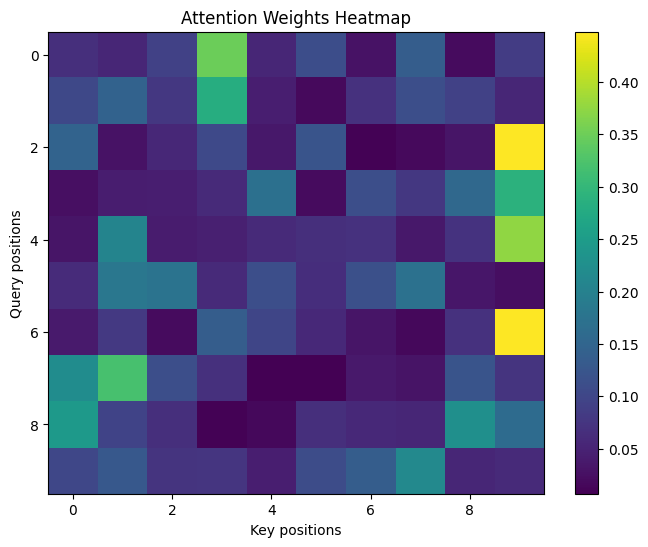

In [3]:
# Visualize attention weights
plt.figure(figsize=(8, 6))
plt.imshow(weights[0].numpy(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Key positions')
plt.ylabel('Query positions')
plt.title('Attention Weights Heatmap')
plt.show()

---
## 2. Encoder-Decoder Architectures

### Theory

**Purpose:** Transform input sequence to output sequence (sequence-to-sequence)

**Architecture:**
1. **Encoder:** Processes input sequence → creates context representation
2. **Decoder:** Uses context → generates output sequence

**Applications:**
- Machine translation (English → French)
- Text summarization (long text → summary)
- Question answering (question → answer)

**With Attention:**
- Decoder attends to all encoder states (not just final state)
- Better handling of long sequences

In [4]:
# Simple Encoder-Decoder with Attention (Pure Attention-based)

class SimpleEncoder(layers.Layer):
    def __init__(self, vocab_size, d_model):
        super(SimpleEncoder, self).__init__()
        self.embedding = layers.Embedding(vocab_size, d_model)
        
    def call(self, x):
        # Just embed the input sequence
        return self.embedding(x)

class SimpleDecoder(layers.Layer):
    def __init__(self, vocab_size, d_model):
        super(SimpleDecoder, self).__init__()
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.attention = SimpleAttention(d_model)
        self.fc = layers.Dense(vocab_size)
        
    def call(self, x, encoder_output):
        # Embed target sequence
        x = self.embedding(x)
        
        # Attention: decoder queries encoder output
        context, attn_weights = self.attention(x, encoder_output, encoder_output)
        
        # Predict output tokens
        output = self.fc(context)
        return output, attn_weights

# Example: English to French translation
vocab_size, d_model = 5000, 128
encoder = SimpleEncoder(vocab_size, d_model)
decoder = SimpleDecoder(vocab_size, d_model)

# Dummy data
input_seq = tf.random.uniform((2, 10), maxval=vocab_size, dtype=tf.int32)  # English
target_seq = tf.random.uniform((2, 8), maxval=vocab_size, dtype=tf.int32)  # French

enc_output = encoder(input_seq)
dec_output, attn_weights = decoder(target_seq, enc_output)

print(f"Encoder output shape: {enc_output.shape}")
print(f"Decoder output shape: {dec_output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

Encoder output shape: (2, 10, 128)
Decoder output shape: (2, 8, 5000)
Attention weights shape: (2, 8, 10)


---
## 3. Transformers

### Theory

**Key Innovation:** Attention is all you need (no RNNs/CNNs)

**Architecture:**
- **Self-Attention:** Q, K, V all from same source  
- **Multi-Head Attention:** Multiple attention in parallel
- **Positional Encoding:** Sequence order information
- **Feed-Forward Network:** Applied to each position

**Advantages:**
- Parallelism (fast training)
- Long-range dependencies
- Scalability

### 3.1 Self-Attention

**Self-Attention:** Query, Key, Value all from the same source

**Example:** "The cat sat on the mat"
- Each word attends to all other words
- Learns relationships: "cat" → "sat", "sat" → "mat"

In [5]:
# Self-Attention Example

# Sentence: "The cat sat on the mat"
sentence_length = 6
d_model = 64

# Simulate word embeddings
sentence_embeddings = tf.random.normal((1, sentence_length, d_model))

# Self-attention: Q, K, V all from same sentence
self_attention = SimpleAttention(d_model)
output, attention_weights = self_attention(
    sentence_embeddings,  # Query
    sentence_embeddings,  # Key
    sentence_embeddings   # Value
)

print(f"Input shape: {sentence_embeddings.shape}")
print(f"Self-attention output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Input shape: (1, 6, 64)
Self-attention output shape: (1, 6, 64)
Attention weights shape: (1, 6, 6)


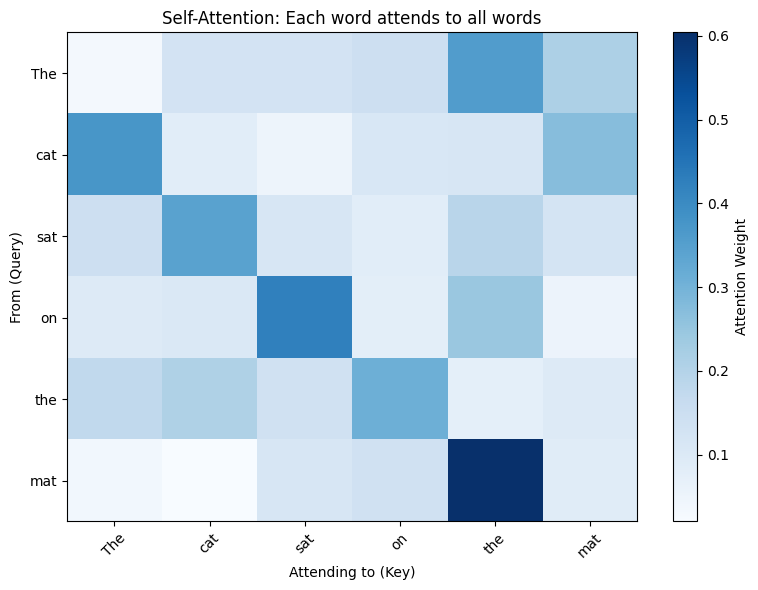


Interpretation:
- Diagonal: Each word attends to itself
- Off-diagonal: Relationships between words
- Brighter color = Higher attention weight


In [6]:
# Visualize Self-Attention

words = ["The", "cat", "sat", "on", "the", "mat"]

plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0].numpy(), cmap='Blues', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xticks(range(len(words)), words, rotation=45)
plt.yticks(range(len(words)), words)
plt.xlabel('Attending to (Key)')
plt.ylabel('From (Query)')
plt.title('Self-Attention: Each word attends to all words')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Diagonal: Each word attends to itself")
print("- Off-diagonal: Relationships between words")
print("- Brighter color = Higher attention weight")

### 3.2 Multi-Head Attention

**Concept:** Run multiple attention operations in parallel

**Why?** Each "head" learns different relationships:
- Head 1: Grammatical relationships
- Head 2: Semantic similarity
- Head 3: Long-range dependencies
- etc.

**Process:**
1. Split embeddings into multiple heads
2. Run attention on each head independently
3. Concatenate and project back

In [ ]:
# Multi-Head Attention

class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        
        # Split into multiple heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention = matmul_qk / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention_weights = tf.nn.softmax(scaled_attention, axis=-1)
        output = tf.matmul(attention_weights, v)
        
        # Concatenate heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        
        # Final linear layer
        output = self.dense(concat_attention)
        return output

# Test
mha = MultiHeadAttention(d_model=128, num_heads=8)
x = tf.random.normal((1, 6, 128))  # "The cat sat on the mat"
output = mha(x, x, x)
print(f"Multi-Head Attention output shape: {output.shape}")

Multi-Head Attention output shape: (1, 6, 128)


### 3.3 Positional Encoding & Feed-Forward Network

In [8]:
# Positional Encoding

def positional_encoding(max_seq_len, d_model):
    """Add position information to embeddings"""
    positions = np.arange(max_seq_len)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]
    
    angles = positions / np.power(10000, (2 * (dims // 2)) / d_model)
    
    # Apply sin to even indices, cos to odd
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])
    
    pos_encoding = angles[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Feed-Forward Network

def point_wise_feed_forward(d_model, dff):
    """Two dense layers with ReLU"""
    return keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])

# Test
pos_enc = positional_encoding(6, 128)
ffn = point_wise_feed_forward(128, 512)
x = tf.random.normal((1, 6, 128))
output = ffn(x)

print(f"Positional encoding shape: {pos_enc.shape}")
print(f"Feed-forward output shape: {output.shape}")

Positional encoding shape: (1, 6, 128)
Feed-forward output shape: (1, 6, 128)


### 3.4 Transformer Encoder & Decoder

In [9]:
# Simple Transformer Encoder (using self-attention)

class SimpleTransformerEncoder(layers.Layer):
    def __init__(self, vocab_size, d_model, num_heads, dff):
        super(SimpleTransformerEncoder, self).__init__()
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(100, d_model)
        
        # Self-attention
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x):
        seq_len = tf.shape(x)[1]
        
        # Embedding + positional encoding
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        
        # Self-attention + residual + norm
        attn_output = self.mha(x, x, x)
        x = self.layernorm1(x + attn_output)
        
        # Feed-forward + residual + norm
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + ffn_output)
        
        return x

# Test
vocab_size, d_model, num_heads, dff = 5000, 128, 8, 512
encoder = SimpleTransformerEncoder(vocab_size, d_model, num_heads, dff)

# Input: "The cat sat on the mat"
input_seq = tf.random.uniform((1, 6), maxval=vocab_size, dtype=tf.int32)
enc_output = encoder(input_seq)

print(f"Encoder output shape: {enc_output.shape}")

Encoder output shape: (1, 6, 128)


In [10]:
# Simple Transformer Decoder (with cross-attention)

class SimpleTransformerDecoder(layers.Layer):
    def __init__(self, vocab_size, d_model, num_heads, dff):
        super(SimpleTransformerDecoder, self).__init__()
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(100, d_model)
        
        # Self-attention (decoder attends to itself)
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        
        # Cross-attention (decoder attends to encoder)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, x, encoder_output):
        seq_len = tf.shape(x)[1]
        
        # Embedding + positional encoding
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        
        # Self-attention + residual + norm
        attn1 = self.mha1(x, x, x)
        x = self.layernorm1(x + attn1)
        
        # Cross-attention to encoder + residual + norm
        attn2 = self.mha2(x, encoder_output, encoder_output)
        x = self.layernorm2(x + attn2)
        
        # Feed-forward + residual + norm
        ffn_output = self.ffn(x)
        x = self.layernorm3(x + ffn_output)
        
        return x

# Test
decoder = SimpleTransformerDecoder(vocab_size, d_model, num_heads, dff)

# Target: "Le chat était assis"
target_seq = tf.random.uniform((1, 4), maxval=vocab_size, dtype=tf.int32)
dec_output = decoder(target_seq, enc_output)

print(f"Decoder output shape: {dec_output.shape}")

Decoder output shape: (1, 4, 128)


### 3.5 Complete Transformer

In [12]:
# Complete Transformer (Encoder + Decoder)

class Transformer(keras.Model):
    def __init__(self, vocab_size, d_model, num_heads, dff):
        super(Transformer, self).__init__()
        
        self.encoder = SimpleTransformerEncoder(vocab_size, d_model, num_heads, dff)
        self.decoder = SimpleTransformerDecoder(vocab_size, d_model, num_heads, dff)
        self.final_layer = layers.Dense(vocab_size)
        
    def call(self, inputs, targets):
        # Encode input
        enc_output = self.encoder(inputs)
        
        # Decode with cross-attention to encoder
        dec_output = self.decoder(targets, enc_output)
        
        # Project to vocabulary
        final_output = self.final_layer(dec_output)
        
        return final_output

# Test complete transformer
transformer = Transformer(vocab_size=5000, d_model=128, num_heads=8, dff=512)

# English: "The cat sat on the mat"
input_seq = tf.random.uniform((1, 6), maxval=5000, dtype=tf.int32)

# French: "Le chat était assis"
target_seq = tf.random.uniform((1, 4), maxval=5000, dtype=tf.int32)

predictions = transformer(input_seq, target_seq)

print(f"\n=== Complete Transformer ===")
print(f"Input (English): {input_seq.shape}")
print(f"Target (French): {target_seq.shape}")
print(f"Predictions: {predictions.shape}")


=== Complete Transformer ===
Input (English): (1, 6)
Target (French): (1, 4)
Predictions: (1, 4, 5000)


In [16]:
input_seq[0, :].numpy()

array([2081,  309, 3275, 3547, 1002, 3843], dtype=int32)

In [15]:
target_seq[0, :].numpy()

array([3251, 2111, 3879, 2231], dtype=int32)

### 3.6 Summary

**Transformer Architecture:**

1. **Encoder:**
   - Embedding + Positional Encoding
   - Multi-Head Self-Attention
   - Feed-Forward Network
   - Layer Norm + Residuals

2. **Decoder:**
   - Embedding + Positional Encoding
   - Multi-Head Self-Attention (masked)
   - Multi-Head Cross-Attention (to encoder)
   - Feed-Forward Network
   - Layer Norm + Residuals

**Key Innovations:**
- No RNNs/CNNs - pure attention
- Parallel processing
- Long-range dependencies
- Scalable to large datasets

**Applications:**
- Machine translation
- Text summarization
- Question answering
- Language models (GPT, BERT)
- Vision (ViT)